<a href="https://colab.research.google.com/github/Y07-assine/Convolutional-Neural-Networks-on-signs-dataset/blob/main/CNN_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks on signs dataset

Import the needed packages

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

Load the 'Signs' dataset

In [2]:
def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

**The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.**

let's show an example of a labelled image in the dataset

y = 2


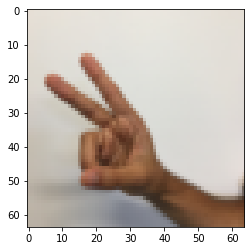

In [4]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Examine the shapes of our data

In [7]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Implement the convolutional_model function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE. Use the functions above!

Also, plug in the following parameters for all the steps:

- Conv2D: Use 8 4 by 4 filters, stride 1, padding is "SAME"
- ReLU
- MaxPool2D: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
- Conv2D: Use 16 2 by 2 filters, stride 1, padding is "SAME"
- ReLU
- MaxPool2D: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
- Flatten the previous output.
- Fully-connected (Dense) layer: Apply a fully connected layer with 6 neurons and a softmax activation.

In [8]:
def convolutional_model(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
  x = tf.keras.layers.Conv2D(8, (4, 4), strides = 1, padding = 'same')(input_img)
  # RELU
  x = tf.keras.layers.ReLU()(x)
  # MAXPOOL: window 8x8, stride 8, padding 'SAME'
  x = tf.keras.layers.MaxPool2D(pool_size = (8, 8), strides = 8, padding = 'same')(x)
  # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
  x = tf.keras.layers.Conv2D(16, (2, 2), strides = 1, padding = 'same')(x)
  # RELU
  x = tf.keras.layers.ReLU()(x)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  x = tf.keras.layers.MaxPool2D(pool_size = (4, 4), strides = 4, padding = 'same')(x)
  #Flatten
  x = tf.keras.layers.Flatten()(x)
  # Dense layer
  # 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
  outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)

  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [9]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0     

- Train the model 

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 3s 107ms/step - loss: 1.8070 - accuracy: 0.1565 - val_loss: 1.7902 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 2s 99ms/step - loss: 1.7900 - accuracy: 0.1741 - val_loss: 1.7856 - val_accuracy: 0.2583
Epoch 3/100
17/17 [==============================] - 2s 99ms/step - loss: 1.7866 - accuracy: 0.2213 - val_loss: 1.7831 - val_accuracy: 0.2917
Epoch 4/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7826 - accuracy: 0.2380 - val_loss: 1.7787 - val_accuracy: 0.2417
Epoch 5/100
17/17 [==============================] - 2s 101ms/step - loss: 1.7767 - accuracy: 0.2509 - val_loss: 1.7734 - val_accuracy: 0.2833
Epoch 6/100
17/17 [==============================] - 2s 99ms/step - loss: 1.7675 - accuracy: 0.2824 - val_loss: 1.7638 - val_accuracy: 0.2417
Epoch 7/100
17/17 [==============================] - 2s 99ms/step - loss: 1.7559 - accuracy: 0.2870 - val_loss: 1.7507 - val_accuracy: 0.2833
Epo

- History Object

In [11]:
history.history

{'accuracy': [0.15648147463798523,
  0.17407406866550446,
  0.2212962955236435,
  0.23796296119689941,
  0.2509259283542633,
  0.28240740299224854,
  0.28703704476356506,
  0.3324074149131775,
  0.3759259283542633,
  0.41296297311782837,
  0.43888887763023376,
  0.46203702688217163,
  0.47870370745658875,
  0.5018518567085266,
  0.5111111402511597,
  0.5249999761581421,
  0.5287036895751953,
  0.539814829826355,
  0.5462962985038757,
  0.5537037253379822,
  0.5620370507240295,
  0.5759259462356567,
  0.5842592716217041,
  0.5916666388511658,
  0.6009259223937988,
  0.6157407164573669,
  0.6240741014480591,
  0.625,
  0.6314814686775208,
  0.635185182094574,
  0.645370364189148,
  0.6527777910232544,
  0.6592592597007751,
  0.6703703999519348,
  0.6851851940155029,
  0.6972222328186035,
  0.7027778029441833,
  0.7129629850387573,
  0.7166666388511658,
  0.7222222089767456,
  0.7231481671333313,
  0.7250000238418579,
  0.7314814925193787,
  0.7361111044883728,
  0.739814817905426,
  0.74

- Let's visualize the loss over time

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

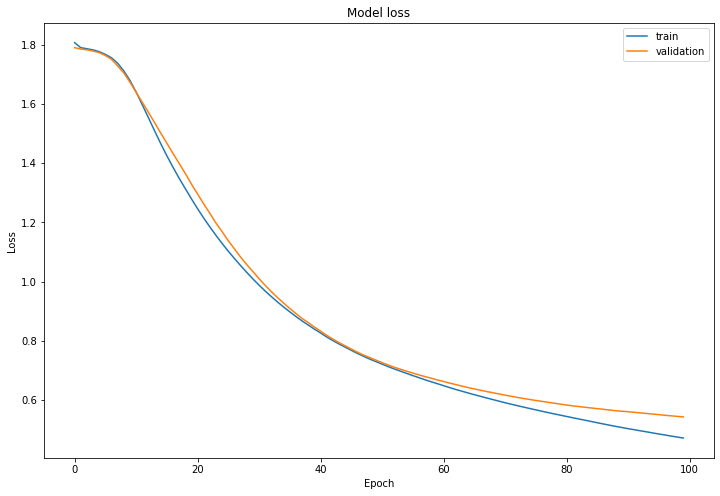

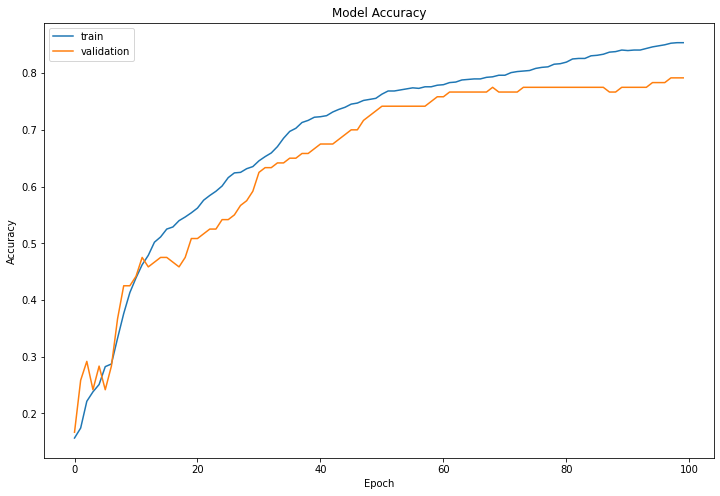

In [12]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')